
# Ungraded Lab: First GAN with MNIST

This lab will demonstrate the simple Generative Adversarial Network (GAN) you just saw in the lectures. This will be trained on the MNIST dataset and you will see how the network creates new images.

https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/4-Generative-deeplearning-with-tensorflow/week-4/C4_W4_Lab_1_First_GAN.ipynb

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Conv2D,
                                     BatchNormalization, Flatten)

In [2]:
def plot_multiple_images(images, n_cols=None, title=""):
  display.clear_output(wait=False)
  n_cols = n_cols or len(images)
  n_rows = (len(images) -1) // n_cols + 1

  if images.shape[-1] == 1:
    images = np.squeeze(images, axis = -1)
  plt.figure(figsize=(n_cols, n_rows))
  plt.figure(facecolor='w')
  for idx, image in enumerate(images):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(image, cmap='binary')
    plt.axis("off")
  plt.savefig(f"./gan_MNIST_generated/{title}", edgecolor=None)



In [3]:
# load the train set of the MNIST dataset
(X_train, _), _ = keras.datasets.mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)


# Generator

The generator takes in random noise and uses it to create fake images. For that, this model will take in the shape of the random noise and will output an image with the same dimensions of the MNIST dataset (i.e. 28 x 28).

SELU is found to be a good activation function for GANs and we use that in the first two dense networks. The final dense networks is activated with a sigmoid because we want to generate pixel values between 0 and 1. This is then reshaped to the dimensions of the MNIST dataset.


In [6]:
random_normal_dimensions=32

ins = keras.layers.Input(shape=[random_normal_dimensions])
x = Dense(64, activation='selu')(ins)
x = Dense(128, activation='selu')(x)
# we want to create a 28x28 img so learn that number of 
# weights so we can reshape those weights to the imag we want  later
x = Dense(28 * 28, activation='sigmoid')(x) 
x = keras.layers.Reshape([28, 28])(x)
generator_model = Model(ins, x, name='generator')
generator_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


<Figure size 288x288 with 0 Axes>

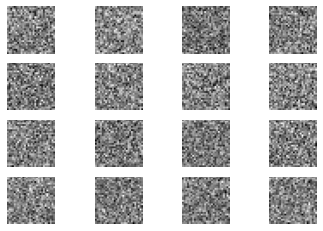

In [7]:
# test our beautiful generator
# gen a batch of noise with batch size = 16
test_noise = tf.random.normal([16, random_normal_dimensions])

test_image = generator_model(test_noise)

plot_multiple_images(test_image, n_cols=4)


# Discriminator

The discriminator takes in the input (fake or real) images and determines if it is fake or not. Thus, the input shape will be that of the training images. This will be flattened so it can be fed to the dense networks and the final output is a value between 0 (fake) and 1 (real).

Like the generator, we use SELU activation in the first two dense networks and we activate the final network with a sigmoid.


In [8]:
ins = keras.layers.Input(shape=[28, 28])
x = keras.layers.Flatten()(ins)
x = Dense(128, activation='selu')(x)
x = Dense(64, activation='selu')(x)
outs = Dense(1, activation='sigmoid')(x)

discriminator_model = Model(ins, outs, name='discriminator')
discriminator_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
_________________________________________________________________


In [9]:
gan = Sequential([generator_model, discriminator_model])
gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Functional)      (None, 28, 28)            111568    
                                                                 
 discriminator (Functional)  (None, 1)                 108801    
                                                                 
Total params: 220,369
Trainable params: 220,369
Non-trainable params: 0
_________________________________________________________________


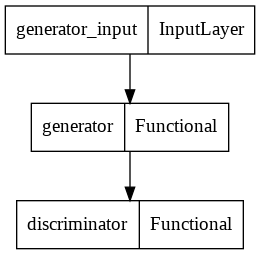

In [10]:
keras.utils.plot_model(gan, expand_nested=False)

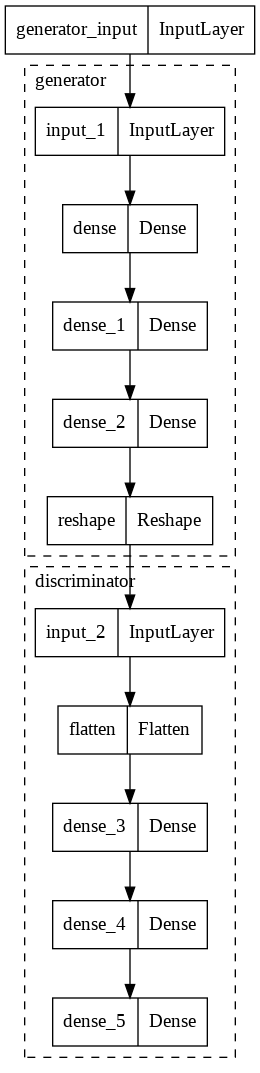

In [11]:
keras.utils.plot_model(gan, expand_nested=True)



# Configure Training Parameters

You will now prepare the models for training. You can measure the loss with binary_crossentropy because you're expecting labels to be either 0 (fake) or 1 (real).


In [12]:
discriminator_model.compile(loss='binary_crossentropy', optimizer='adam')
discriminator_model.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="adam")


# Train the Model

Next, you will define the training loop. This consists of two phases:

    - Phase 1 - trains the discriminator to distinguish between fake or real data
    - Phase 2 - trains the generator to generate images that will trick the discriminator

At each epoch, you will display a sample gallery of images to see the fake images being created by the generator. The details of how these steps are carried out are shown in the code comments below.


In [13]:
gan.layers

In [14]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
      t = "Epoch %d-%d"% (epoch+1, n_epochs)
      print(t)
      for real_imgs in dataset:
        batch_size = real_imgs.shape[0]

        ### Phase 1, train discriminator
        noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
        fake_images = generator(noise)

        # create a list by concatenating the real and fake images
        mixed_images = tf.concat([fake_images, real_imgs], axis=0)
        # discriminator labels are 0 for fake and 1 for real image
        discriminator_labels = tf.constant([[0.]]* batch_size + [[1.]]* batch_size)
        discriminator.trainable=True
        discriminator.train_on_batch(mixed_images, discriminator_labels)

        ### Phase 2 train the generator
        noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
        discriminator.trainable=False # freeze the discriminator
        # label all generated images to be "real"
        generator_labels = tf.constant([[1.]] * batch_size)
        # Train the GAN on the noise with the labels all set to be true
        gan.train_on_batch(noise, generator_labels)
      # plot the fake images used to train the discriminator
      plot_multiple_images(fake_images, 13, title=t)                     
      plt.show()
      


<Figure size 936x720 with 0 Axes>

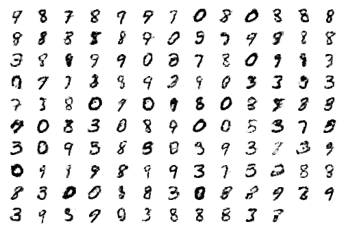

In [15]:
train_gan(gan, dataset, random_normal_dimensions, n_epochs=100)

You might notice that as the training progresses, the model tends to be biased towards a subset of the numbers such as 1, 7, and 9. We'll see how to improve this in the next sections of the course.